In [2]:
# enable auto-reload of sources
%load_ext autoreload
%autoreload 2
# import tensorboard backend
from tensorboard.backend.event_processing import event_accumulator

In [1]:
import os
os.chdir('../')

In [2]:
%reload_ext tensorboard
%tensorboard --logdir "models/disentangle_losses"

In [3]:
base_dir = 'models'

In [4]:
# set log dir of harmonized model
harm_log_dir = 'logs/harm/lightning_logs/version_5/'
raw_log_dir = 'logs/raw/lightning_logs/baba/'
raw_log_dir = 'logs/raw/lightning_logs/version_26/'
raw_scanvi_log_dir = 'logs/scanvi/lightning_logs/version_22'
log_dir = raw_scanvi_log_dir

In [5]:
log_dir = os.path.join(base_dir, 'lightning_logs/version_1')
# Load the event accumulator
event_acc = event_accumulator.EventAccumulator(log_dir)
event_acc.Reload()

# Check available tags (e.g., scalars, histograms, images)
tags = event_acc.Tags()

2025-01-29 11:55:50.791985: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 11:55:50.848140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
import pandas as pd

results = []
tags = [t for t in tags['scalars'] if t != 'hp_metric']
for tag in tags:
    scalar_data = event_acc.Scalars(tag)
    # Extract the step and value from the scalar data
    steps = [entry.step for entry in scalar_data]
    values = [entry.value for entry in scalar_data]
    # Store the data in the dictionary
    results.append(pd.DataFrame({'tag': tag, 'step': steps, 'value': values}))

results = pd.concat(results)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(data, mode='train',
                 targets=['cell_type_acc', 'pert_acc', 'precision', 'recall'],
                 target_labels=['Perturbation precision', 'Perturbation recall', 'Cell type accuracy', 'Perturbation accuracy'],
                 **plot_args):
    targets = [f'{mode}_{t}' for t in targets]
    df = data[data.tag.isin(targets)].copy()
    df.tag = df.tag.str.split('_').str[1:].str.join(' ')
    # plot 
    fig, ax = plt.subplots()
    ax = sns.lineplot(df, x='step', y='value', hue='tag', **plot_args)
    plt.title(f'{mode.capitalize()}. Metrics')
    plt.xlabel('Steps')
    plt.ylabel('Value')
    # Get current legend
    handles, labels = plt.gca().get_legend_handles_labels()
    # Rename the legend labels if alternatives are given
    labels = target_labels if target_labels else labels
    # Reapply the legend with the new labels
    plt.legend(handles=handles, labels=labels, title='Metrics', bbox_to_anchor=(1.5, 0.5), loc='lower center')
    plt.tight_layout()
    plt.minorticks_on()  # Enable minor ticks
    plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5)
    plt.show()

In [8]:
results.tag.unique()

array(['train_loss_step', 'epoch', 'train_loss_epoch', 'elbo_train',
       'reconstruction_loss_train', 'kl_local_train', 'kl_global_train',
       'train_classification_loss', 'train_accuracy', 'train_f1_score',
       'train_calibration_error'], dtype=object)

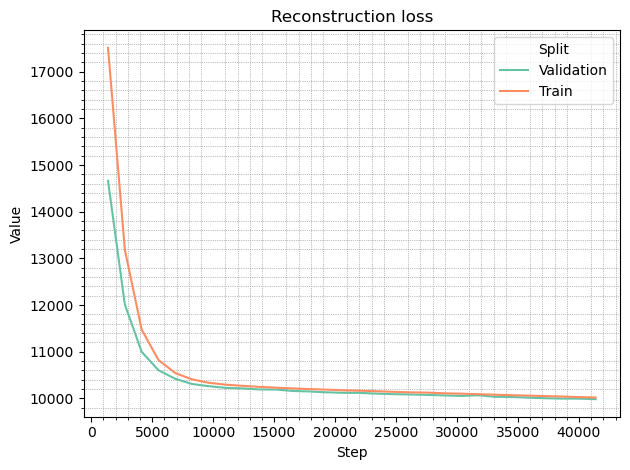

In [38]:
# plot reconstruction loss
pl_df = results[results.tag.str.startswith('reconstruction')].copy()
pl_df.columns = ['Metric', 'Step', 'Value']
pl_df['Split'] = pl_df.Metric.str.split('_').str[2].str.capitalize()

fig, ax = plt.subplots()
sns.lineplot(pl_df, x='Step', y='Value', hue='Split', ax=ax, palette='Set2')
plt.title('Reconstruction loss')
plt.tight_layout()
plt.minorticks_on()
plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5)
plt.show()

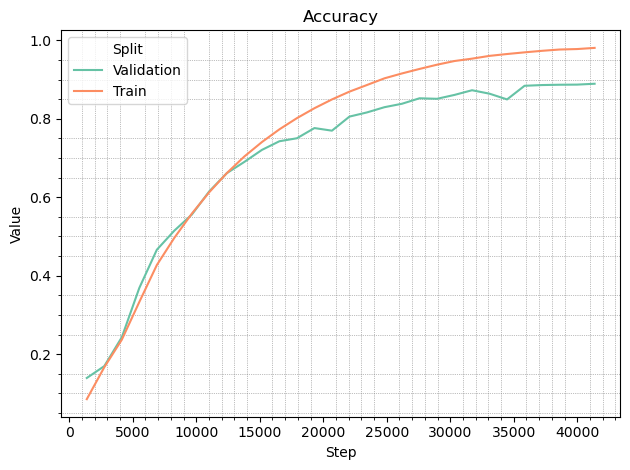

In [35]:
# plot accuracy
pl_df = results[results.tag.str.endswith('accuracy')].copy()
pl_df.columns = ['Metric', 'Step', 'Value']
pl_df['Split'] = pl_df.Metric.str.split('_').str[0].str.capitalize()

fig, ax = plt.subplots()
sns.lineplot(pl_df, x='Step', y='Value', hue='Split', ax=ax, palette='Set2')
plt.title('Accuracy')
plt.tight_layout()
plt.minorticks_on()
plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5)
plt.show()

In [7]:
targets = ['accuracy']

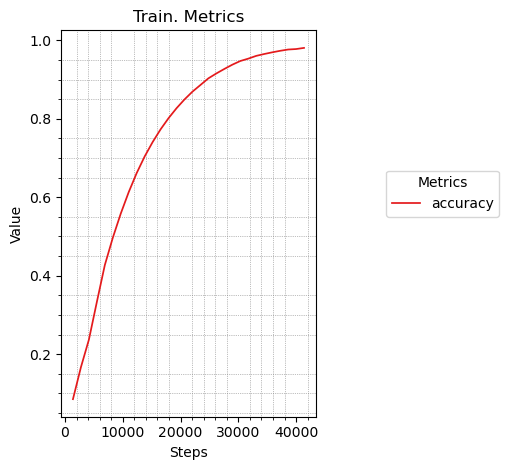

In [8]:
plot_metrics(results, mode='train',
             targets=targets,
             palette='Set1', target_labels=None, linewidth=1.25)

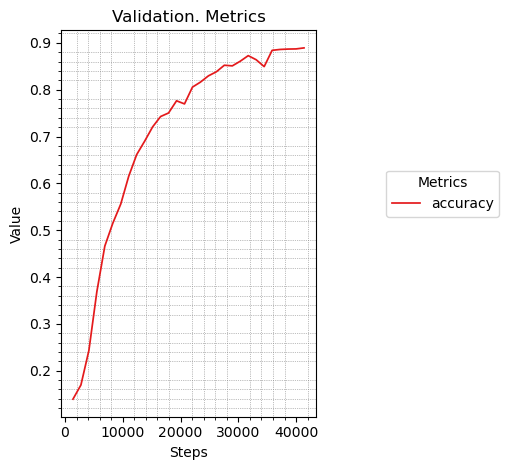

In [9]:
plot_metrics(results, mode='validation',
             targets=targets,
             palette='Set1', target_labels=None, linewidth=1.25)

/tmp/ipykernel_61014/2431898103.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(df, x='step', y='value', hue='tag', **plot_args)
/tmp/ipykernel_61014/2431898103.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=labels, title='Metrics', bbox_to_anchor=(1.5, 0.5), loc='lower center')


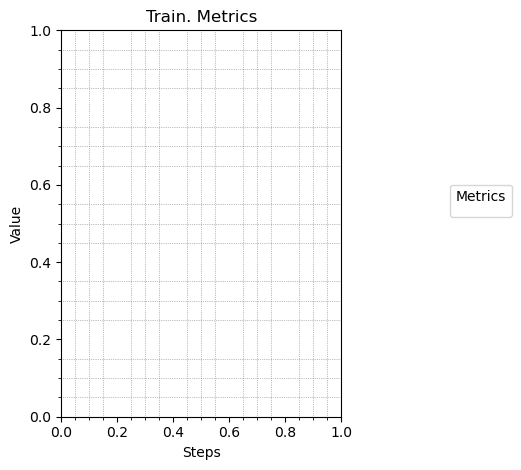

In [9]:
plot_metrics(results, mode='train', palette='Set1', target_labels=None, linewidth=1.25)

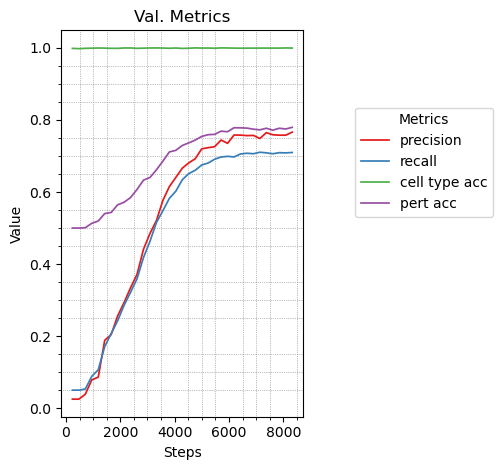

In [24]:
plot_metrics(results, mode='val', palette='Set1', target_labels=None, linewidth=1.25)

In [25]:
loss_targets = results.tag[results.tag.str.startswith('train') & results.tag.str.contains('loss')].str.split('_').str[1:].str.join(sep='_').unique()

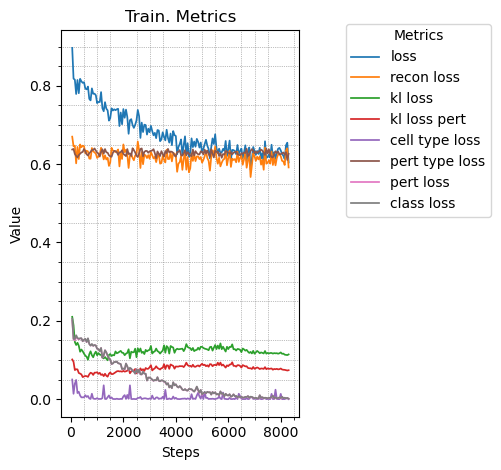

In [26]:
plot_metrics(results, mode='train',
             targets=loss_targets,
             target_labels=None, linewidth=1.25)

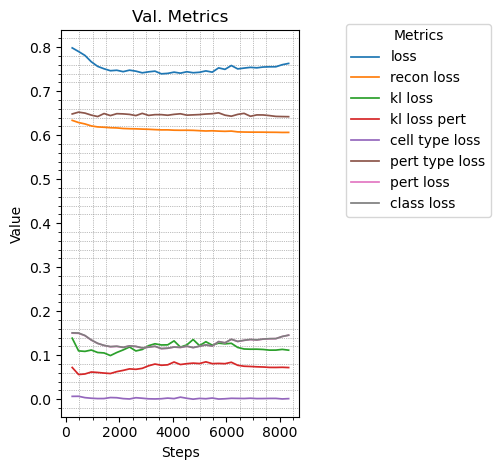

In [27]:
plot_metrics(results, mode='val',
             targets=loss_targets,
             target_labels=None, linewidth=1.25)

In [ ]:
# loading models from checkpoint
use_checkpoint = False

if use_checkpoint:
    from src.multivae import MultiPropertyVAE
    # load model from checkpoint
    checkpoint_p = 'logs/raw/lightning_logs/baba/checkpoints/epoch=3-step=228.ckpt'
    multi_model = MultiPropertyVAE.load_from_checkpoint(checkpoint_p)